In [16]:
import os
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms
import torchvision.datasets as dsets

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting path/MNIST/raw/train-images-idx3-ubyte.gz to path/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting path/MNIST/raw/train-labels-idx1-ubyte.gz to path/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting path/MNIST/raw/t10k-images-idx3-ubyte.gz to path/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting path/MNIST/raw/t10k-labels-idx1-ubyte.gz to path/MNIST/raw

Processing...
Done!
Size dataset 60000 images.
Possible classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Image Object: <PIL.Image.Image image mode=L size=28x28 at 0x7F24B0214FD0> - Class 5
Details of the image (28, 28) pixels


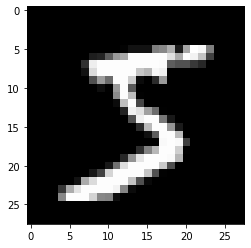

In [22]:

mnist_dataset = dsets.MNIST("path", download=True)

print(f"Size dataset {len(mnist_dataset)} images.")
print(f"Possible classes: {mnist_dataset.classes}")

data_idx = 0
image, label = mnist_dataset[0] 

print(f"Image Object: {image} - Class {label}")
print(f"Details of the image {image.size} pixels")

plt.imshow(image, cmap='gray')
plt.show()

In [24]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download datasets
mnist_train_dataset = dsets.MNIST("path", download=True, train=True, transform=transform)

# Split in train and validation dataset
train_set, val_set = torch.utils.data.random_split(mnist_train_dataset, [int(0.8 * len(mnist_train_dataset)), int(0.2 * len(mnist_train_dataset))])

mnist_test_dataset = dsets.MNIST("path", download=True, train=False, transform=transform)

BATCH_SIZE = 32

# Crate loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [25]:
# Input:
#        - training_model: neural net to train.
#        - loader: DataLoader with training data.
#        - criterion: loss function.
#        - optim: optimizer in charge of updating model parameters based on computed gradients.
# Output:
#        - average loss of the epoch
#        - % of accuracy score
#        - % of precission score
#        - % of recall score
#        - % of F1 score
def train_epoch(training_model, loader, criterion, optim):
    # set model to train state
    training_model.train()
    
    epoch_loss = 0.0
    
    all_labels = []
    all_predictions = []

    for images, labels in loader:
        # add mini-batch targets (tensor to list) to the end of 'all_labels' list
        all_labels.extend(labels.numpy())

        # reset gradients
        optim.zero_grad()

        # predict and save result to 'all_predictions' list
        # mini-batch images are mounted to the GPU
        predictions = training_model(images.to(device))

        # using cpu to get the class with highest value returned by the net
        all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

        # mount labels to GPU and calculate loss comparing them with model predictions
        loss = criterion(predictions, labels.to(device))
        loss.backward()

        # Backprop, compute gradients and update model parameters
        optim.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100, precision_score(all_labels, all_predictions, average="weighted") * 100, recall_score(all_labels, all_predictions, average="weighted") * 100 , f1_score(all_labels, all_predictions, average="weighted") * 100


In [26]:
# Input:
#        - val_model: neural net to validate.
#        - loader: DataLoader with validation data.
#        - criterion: loss function.
# Output:
#        - average loss of the validation epoch
#        - % of accuracy score
#        - % of precission score
#        - % of recall score
#        - % of F1 score
def validation_epoch(val_model, loader, criterion):
    # set model to test state
    val_model.eval()
  
    epoch_loss = 0.0
    all_labels = []
    all_predictions = []
    with torch.no_grad(): # temporarily set all the requires_grad flag to false
      for images, labels in loader:
          all_labels.extend(labels.numpy())
    
          predictions = val_model(images.to(device))
          all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())
    
          loss = criterion(predictions, labels.to(device))
    
          epoch_loss += loss.item()
    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100, precision_score(all_labels, all_predictions, average="weighted") * 100, recall_score(all_labels, all_predictions, average="weighted") * 100 , f1_score(all_labels, all_predictions, average="weighted") * 100


In [27]:
# Input:
#        - model: neural net to train.
#        - train_loader: DataLoader with train data.
#        - validation_loader: DataLoader with validation data.
#        - criterion: loss function.
#        - optim: optimizer in charge of updating model parameters based on computed gradients.
# Output:
#        - train_history: list with the average loss of each training epoch
#        - validation_history: list with the average loss of each validation epoch
def train_model(model, train_loader, validation_loader, criterion, optim, number_epochs):
  train_history = []
  validation_history = []

  for epoch in range(number_epochs):
      # track time for each epoch
      start_time = time.time()

      # Training epoch
      train_loss, train_acc, train_prec, train_recall, train_f1 = train_epoch(model, train_loader, criterion, optim)
      train_history.append(train_loss)
      print("Training epoch {} | Loss {:.6f} | Accuracy {:.2f}% | F1 {:.2f}% | Precision {:.2f}% | Recall {:.2f}% | Time {:.2f} seconds"
            .format(epoch + 1, train_loss, train_acc, train_f1, train_prec, train_recall, time.time() - start_time))

      # Validation epoch
      start_time = time.time()
      valid_loss, valid_acc, valid_prec, valid_recall, valid_f1 = validation_epoch(model, validation_loader, criterion)
      validation_history.append(valid_loss)
      print("Validation epoch {} | Loss {:.6f} | Accuracy {:.2f}% | F1 {:.2f}% | Precision {:.2f}% | Recall {:.2f}% | Time {:.2f} seconds"
            .format(epoch + 1, valid_loss, valid_acc, valid_f1, valid_prec, valid_recall, time.time() - start_time))

  return train_history, validation_history

In [28]:
def test_model(model, test_loader):
    # Performance in test dataset
    with torch.no_grad():
        correct_predictions = 0.0

        for i, data in enumerate(test_loader):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            predictions = model(images)
            predictions = torch.argmax(predictions, dim=1)

            correct_predictions += (predictions == labels).detach().cpu().float().sum().item()

    print(f"Test set accuracy {(100 * correct_predictions / len(test_loader.dataset)):.2f} %")

In [29]:
class ConvolutionalModel(nn.Module):
    def __init__(self, number_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1)
        
        self.pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)   # Regions of 2x2 with step 2.
        # These images are of size 28x28 and we'll apply two times the Pooling layer
        # As a result we'll obtaing images of size 7x7 (28 / 2 / 2).
        
        self.fc1 = nn.Linear(in_features=7*7*8, out_features=128) 
        
        self.output = nn.Linear(in_features=128, out_features=number_classes)
        

    def forward(self, new_input):
        result = self.conv1(new_input)
        result = F.relu(self.pooling_layer(result))
        
        result = self.conv2(result)
        result = F.relu(self.pooling_layer(result))     
        
        result = result.reshape((-1, self.fc1.in_features))
        result = F.relu(self.fc1(result))
        
        return self.output(result)

In [30]:
conv_model = ConvolutionalModel(number_classes=10).to(device)

LEARNING_RATE = 0.03
NUMBER_EPOCHS = 15

criterion = nn.CrossEntropyLoss().to(device)
conv_optimizer = optim.SGD(conv_model.parameters(), lr=LEARNING_RATE, momentum=0.9)

train_loss, valid_loss = train_model(conv_model, train_loader, val_loader, criterion, conv_optimizer, NUMBER_EPOCHS)

Training epoch 1 | Loss 0.201181 | Accuracy 93.48% | F1 93.49% | Precision 93.51% | Recall 93.48% | Time 10.55 seconds
Validation epoch 1 | Loss 0.084040 | Accuracy 97.52% | F1 97.52% | Precision 97.54% | Recall 97.52% | Time 2.27 seconds
Training epoch 2 | Loss 0.071539 | Accuracy 97.84% | F1 97.83% | Precision 97.83% | Recall 97.84% | Time 10.62 seconds
Validation epoch 2 | Loss 0.059355 | Accuracy 98.12% | F1 98.13% | Precision 98.14% | Recall 98.12% | Time 2.31 seconds
Training epoch 3 | Loss 0.058698 | Accuracy 98.20% | F1 98.20% | Precision 98.20% | Recall 98.20% | Time 10.67 seconds
Validation epoch 3 | Loss 0.061643 | Accuracy 98.16% | F1 98.16% | Precision 98.18% | Recall 98.16% | Time 2.31 seconds
Training epoch 4 | Loss 0.049551 | Accuracy 98.48% | F1 98.48% | Precision 98.48% | Recall 98.48% | Time 10.50 seconds
Validation epoch 4 | Loss 0.064815 | Accuracy 97.98% | F1 97.99% | Precision 98.01% | Recall 97.98% | Time 2.30 seconds
Training epoch 5 | Loss 0.041783 | Accuracy 

In [31]:
test_model(conv_model, test_loader)


Test set accuracy 98.07 %
